<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Исследование-влияния-признаков-на-целевую-метрику." data-toc-modified-id="Исследование-влияния-признаков-на-целевую-метрику.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование влияния признаков на целевую метрику.</a></span></li><li><span><a href="#Разработка-алгоритма" data-toc-modified-id="Разработка-алгоритма-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разработка алгоритма</a></span></li><li><span><a href="#Проверка-алгоритма-на-валидационной-выборке" data-toc-modified-id="Проверка-алгоритма-на-валидационной-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма на валидационной выборке</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Сопоставление товаров

В ходе проекта мы решаем задачу сопоставления и поиска похожих товаров. Сопоставление или “мэтчинг” (англ. matching - соответствия) - одна из базовых задач машинного обучения, которая встречается в информационном поиске, компьютерном зрении, рекомендательных системах и др. В нашем распоряжении реальные сырые данные одного из крупнейших маркетплейсов страны. Цель проекта - разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`. Критерием качества алгоритма выступает метрика `accuracy@5`. Выбранная метрика показывает, как часто похожий товар будет находиться среди пяти предложенных алгоритмом.

In [1]:
# !pip install faiss-cpu

## Обзор данных

In [2]:
import os
import warnings
from itertools import chain, combinations, permutations

import faiss
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
SEED = 12345

display(HTML('<style>.container { width:90% !important; }</style>'))
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [4]:
def get_df(file_name, data_type=None):
    path_to_file = os.path.relpath(os.path.join('datasets', file_name))
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file, index_col=0, dtype=data_type)
    raise Exception(f'Файл "{file_name}" не найден')

In [5]:
float_columns_dict = {str(num): 'float32' for num in range(72)}

In [6]:
df_base = get_df('base.csv', data_type=float_columns_dict)
df_train = get_df('train.csv', data_type=float_columns_dict)
features_valid = get_df('validation.csv', data_type=float_columns_dict)
df_target_valid = get_df('validation_answer.csv')

In [7]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


In [8]:
df_train.info()
features_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

In [9]:
df_base.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
4486839-base,-116.880554,16.079739,-35.236443,-156.314087,99.582939,-42.706894,-448.544373,134.853668,125.130005,89.486588,...,-88.364273,-60.585121,-150.507645,-77.161812,69.886978,-9.490435,57.238411,124.380402,-79.587189,-72.913567
4350486-base,-73.979645,14.080088,-50.173866,-130.460556,55.819931,-101.619247,-494.691925,89.738899,128.920578,82.838799,...,-34.651821,-0.969040,-157.467880,54.735416,64.952003,-9.642574,108.992416,113.601410,43.605141,-46.695068
124482-base,-52.850906,-4.135958,-75.554947,-141.313385,81.694992,-71.324844,-749.343140,-0.831781,119.628380,61.655914,...,-133.290268,34.281750,-131.256241,154.424927,66.362152,-17.474518,32.438320,112.209587,-1061.738647,-100.502510
1800106-base,-46.834965,6.512112,-70.798134,-170.777679,99.586800,-79.955681,-759.626038,25.379755,142.265366,144.980972,...,-112.445694,35.101349,-153.782700,-97.976974,64.779381,-15.946533,90.978859,120.474350,-1074.464844,-94.202263
1658880-base,-81.665565,12.312473,-74.429031,-110.071564,146.546555,-101.875626,-183.218506,45.357975,119.536613,90.461258,...,-40.740009,36.624790,-191.807861,165.963791,67.775963,32.094749,69.130516,122.293671,-1074.464844,-27.640423


In [10]:
df_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
59239-query,-104.717834,7.734668,-23.552799,-174.425308,143.096970,-35.691360,-366.473755,5.613538,111.007027,125.777565,...,19.679337,-114.875076,175.823196,67.451004,-20.020077,85.371902,126.477989,-1017.723145,-19.413708,2459973-base
62361-query,-78.251419,5.153999,-4.092640,-150.660965,128.649216,-101.914093,-763.375366,99.491898,117.686569,134.344299,...,44.076950,-132.940720,55.623726,66.437363,-15.695633,162.225388,140.769318,-1074.464844,-1.187744,3548569-base
88168-query,-146.759247,5.998984,-16.732342,-148.585144,134.350815,-71.135857,-26.998362,-53.301086,125.122673,62.354149,...,21.547808,-132.179932,17.783426,66.921608,-21.839092,150.439743,127.879044,9.396559,-52.293098,888811-base
75497-query,-93.929100,2.620737,-44.290173,-156.606339,137.574890,-38.017956,-530.124695,-41.300217,121.218987,104.517700,...,35.513508,-162.635254,6.718405,69.313446,-10.781012,10.313755,121.455460,-658.402527,-61.135967,530550-base
47514-query,-105.377411,9.412529,-41.748840,-151.882156,183.028320,-93.819031,-650.863159,10.709978,137.712921,156.168747,...,28.239767,-132.824005,97.654083,68.566025,-40.269062,22.145058,140.216751,-1074.464844,-100.954819,2055330-base


In [11]:
features_valid.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
113334-query,-116.005058,8.542494,-53.197559,-142.157013,158.192017,-101.342522,-468.645538,13.277334,122.032555,183.058395,...,-131.644699,17.397911,-128.296036,62.326778,65.426842,-92.683899,19.898327,86.816833,-207.084946,-14.556763
157307-query,-71.389420,6.153344,-52.317734,-166.589920,124.642380,-98.626213,-513.393860,-19.946936,128.794098,90.124710,...,-47.840221,-18.924908,-108.671295,-16.493622,65.615845,-141.747223,42.933346,79.471939,-1074.464844,-91.707710
109861-query,-83.293648,6.799582,-43.842644,-128.777695,201.098465,-89.841949,-373.883636,131.484772,129.455734,56.045738,...,-51.874630,-23.111259,-169.919464,-72.395256,67.333275,62.987743,125.010498,146.945343,-1182.135986,-76.097260
183191-query,-99.474602,6.818039,-5.127964,-136.200256,-2.190918,-96.729347,-30.957573,-15.281046,126.141899,77.683334,...,-71.031380,55.135361,-99.247055,66.748451,65.173576,-35.033985,56.430637,83.195358,-817.473999,-107.350113
104034-query,-54.300007,2.119474,-56.305004,-139.038757,128.912567,-88.241020,-530.124695,56.346573,128.773987,117.112946,...,-90.507179,4.179214,-203.119965,-99.320992,64.584953,-4.691641,53.428368,85.727005,-688.305847,-44.576317


In [12]:
def get_overview_histogram(df, col, ax, bins_num='auto',
                           color=None, alpha=.4):
    sns.histplot(df[col], kde=True, color=color,
                 bins=bins_num, alpha=alpha, ax=ax)
    ax.set_ylabel('Количество')
    


def get_overview(df_1, df_2, cols):
    rows_num = df_2.shape[1] // 3 + 1
    fig, axs = plt.subplots(rows_num, 3, figsize=(15, 45))
    axis_to_del = 3 - df_2.shape[1] % 3
    while axis_to_del:
        fig.delaxes(axs[-1][-axis_to_del])
        axis_to_del -= 1
    for col, ax in tqdm(zip(cols, axs.flat)):
        get_overview_histogram(df_1, col, ax)
        get_overview_histogram(df_2, col, ax,
                               color='sandybrown', alpha=.4)
    plt.tight_layout()
    plt.show()

72it [01:45,  1.47s/it]


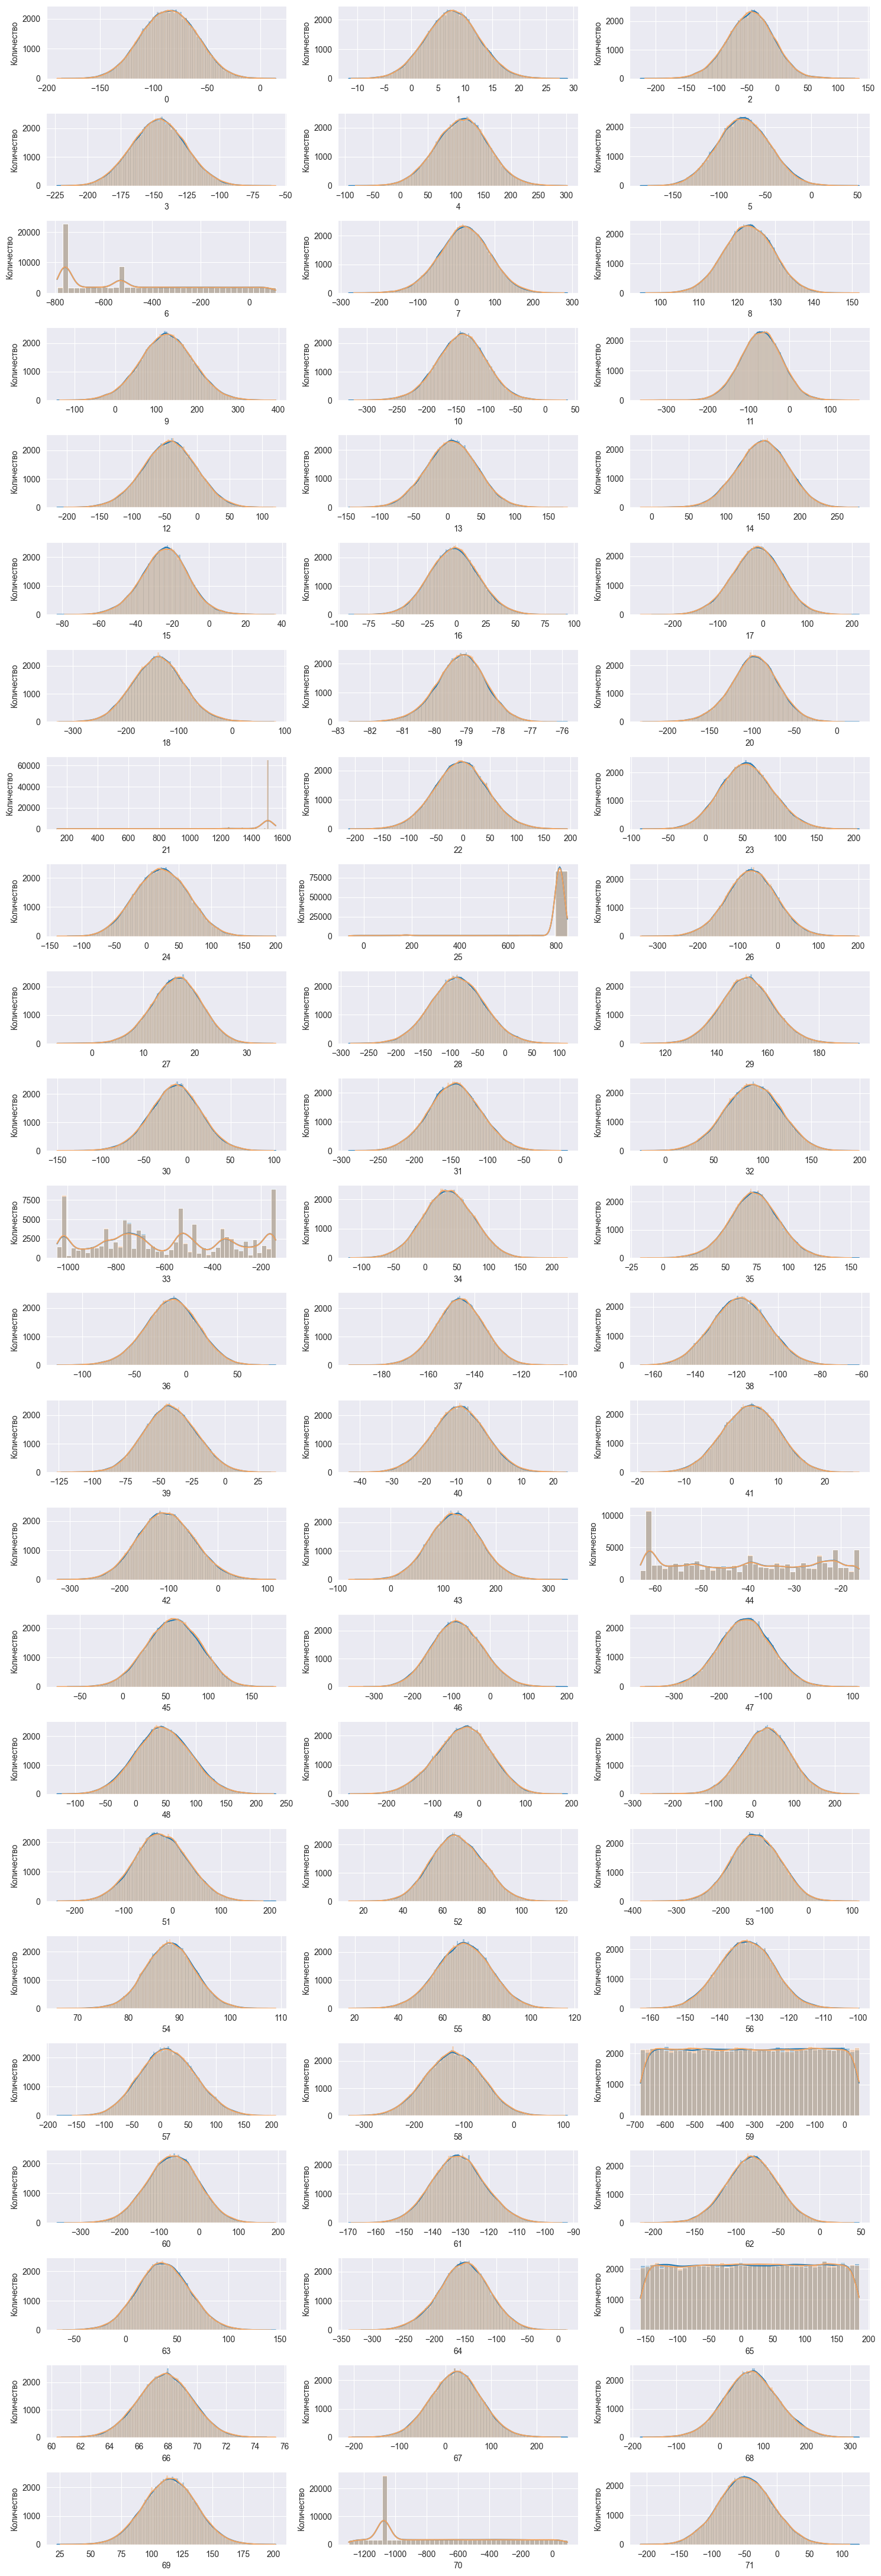

In [13]:
get_overview(df_train, features_valid, features_valid.columns)

In [14]:
df_train.duplicated().sum()

0

Взглянем подробнее на признаки с распределением, отличным от нормального.

In [15]:
less_than_6 = df_base['70'].value_counts()[lambda x: x < 6].index

In [16]:
less_than_6.shape[0] / df_base.shape[0]

0.5232430668998289

Примерно для 52% объектов в наборе данных `base.csv` значение признака `70` либо уникальное, 
либо таких значений не более пяти.

In [17]:
ids = np.intersect1d(df_train['Target'].values, df_base.index)
df_train = pd.merge(
    df_train, df_base.loc[ids, ['70', '6']], how='left',
    left_on='Target', right_index=True, suffixes=(None, '_base')
)

In [18]:
df_train.loc[(df_train['70'] == df_train['70_base']), ['70', '70_base']]

,70,70_base
Id,,
0-query,-415.750244,-415.750244
2-query,-1074.464844,-1074.464844
4-query,-1074.464844,-1074.464844
5-query,-800.428650,-800.428650
6-query,-44.371929,-44.371929
...,...,...
99990-query,-0.953800,-0.953800
99993-query,-1012.473511,-1012.473511
99994-query,68.828453,68.828453


В обучающей выборке, примерно в 72% случаев, значение признака `70` для вектора, переданного в запросе, будет совпадать со значением соответствующей переменной искомого объекта.

In [19]:
df_train.loc[(df_train['70'] == df_train['70_base'])
             & (df_train['70'].isin(less_than_6))]

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,Target,70_base,6_base
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base,-415.750244,-347.360596
5-query,-92.844185,2.975510,-61.760483,-171.675461,144.798370,-58.685143,104.112907,75.844582,118.336227,81.981125,...,86.282089,64.678535,64.527603,64.664436,126.914597,-800.428650,-30.197390,2381316-base,-800.428650,104.112907
6-query,-127.996582,9.672705,-37.678322,-141.413040,119.940926,-76.850456,-15.455418,75.031219,128.762985,266.939575,...,139.211136,69.942123,21.280258,76.636414,85.143051,-44.371929,-15.524637,773187-base,-44.371929,-15.455418
10-query,-80.497215,4.198283,22.420013,-135.298889,119.971931,-81.749275,-530.124695,117.829231,128.167801,129.974716,...,149.374634,67.501175,32.233040,86.700897,121.777611,-640.529175,-60.236816,1790410-base,-640.529175,-530.124695
12-query,-25.965710,5.871690,-72.787704,-152.229141,99.072441,-70.789040,-480.520386,38.896404,126.906067,81.909790,...,17.389435,68.662842,27.097340,6.214474,123.546616,-492.145569,-91.472610,338682-base,-492.145569,-480.520386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99990-query,-38.032570,11.494578,-19.129005,-152.188660,160.067352,-34.408794,69.050209,-49.531387,122.104393,215.504089,...,-23.577913,65.918846,18.661448,17.368996,93.971550,-0.953800,-73.877998,616075-base,-0.953800,69.050209
99993-query,-76.346024,14.800076,-24.211578,-133.334457,98.876976,-93.111603,-530.124695,173.526978,120.684021,37.194855,...,-84.248123,70.720329,-36.345016,65.404022,118.099808,-1012.473511,-34.520767,842280-base,-1012.473511,-512.605225
99994-query,-114.154488,5.883811,-38.780025,-83.961853,176.993469,-34.289211,-464.206024,137.827087,125.575851,131.750122,...,64.826973,69.589165,-33.972168,110.797928,103.112701,68.828453,-30.488008,1372724-base,68.828453,-464.206024


Поиск пяти ближайших соседей только по признаку `70` позволит получить целевую метрику, равную примерно 60.

In [20]:
less_than_6 = df_base['6'].value_counts()[lambda x: x < 6].index
less_than_6.shape[0] / df_base.shape[0]

0.6339725420893247

In [21]:
df_train.loc[(df_train['6'] == df_train['6_base'])
             & (df_train['6'].isin(less_than_6))].shape[0]

45125

Выполняя поиск пяти ближайших соседей по признаку `6` мы получим `accuracy@5`, равную 45.  

Остальные переменные рассмотрим в ходе дальнейшего исследования.

In [22]:
df_train = df_train.drop(['70_base', '6_base'], axis=1)

**Вывод**:  
- распределения признаков обучающей выборки соответствуют распределениям валидационной выборки;    
- распределения основной части переменных приблизительно нормальные;  
- в наборе данных присутствуют равномерно распределённые признаки;  
- явные дубликаты отсутствуют;    
- поиск пяти ближайших соседей только по признаку `70` позволяет получить целевую метрику, примерно равную 60.

## Исследование влияния признаков на целевую метрику.

In [23]:
not_norm = ['6', '21', '25', '33', '44', '59', '65', '70']

In [24]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [25]:
base_columns = df_base.columns.to_list()
target_train = df_train['Target']
features_train = df_train.drop('Target', axis=1)

In [26]:
def get_nearest_vectors(cols, k=5, n=1000, col_70=False,
                        base=df_base, base_idx=base_index,
                        features=features_train, target=target_train):
    if len(cols) != 1:
        scaler = StandardScaler()
        local_base = np.ascontiguousarray(scaler.fit_transform(base[cols]))
        local_features = np.ascontiguousarray(scaler.transform(features[cols]))
    else:
        local_base = np.ascontiguousarray(base[cols].values)
        local_features = np.ascontiguousarray(features[cols].values)

    if col_70:
        local_base[:, -1] = base[col_70]
        local_features[:, -1] = features[col_70]
    dimensions = local_base.shape[1]

    index = faiss.IndexFlatL2(dimensions)
    if k == 5 or len(cols) == 1:
        nlist = n
        quantizer = faiss.IndexFlatL2(dimensions)
        index = \
            faiss.IndexIVFFlat(quantizer, dimensions, nlist, faiss.METRIC_L2)
        index.train(np.ascontiguousarray(local_base))
    index.add(np.ascontiguousarray(local_base))

    D, I = index.search(local_features, k)
    nearest_vectors = [[base_idx.get(vector) for vector in item] for item in I]
    index.reset

    is_target = [
        trgt in item
        for trgt, item in zip(target.values.tolist(), nearest_vectors)
    ]
    return is_target, nearest_vectors

Проверим, как удаление признака, не подчиняющегося закону нормального распределения, влияет на целевую метрику.

In [27]:
%%time
initial_scores = {}
i = 0
for col in tqdm(not_norm):
    base_columns.pop(int(col) - i)
    is_target, vectors = get_nearest_vectors(base_columns)
    accuracy_at_5 = 100 * sum(is_target) / df_train.shape[0]
    if col == '70':
        vectors_norm = vectors
    initial_scores[col] =  accuracy_at_5
    i += 1

100%|██████████| 8/8 [01:49<00:00, 13.68s/it]

CPU times: total: 17min 43s
Wall time: 1min 49s


In [28]:
norm_columns = base_columns
initial_scores

{'6': 51.32,
 '21': 52.472,
 '25': 54.093,
 '33': 57.442,
 '44': 57.994,
 '59': 59.921,
 '65': 60.888,
 '70': 61.147}

In [29]:
not_norm_combinations = list(
    chain.from_iterable(combinations(not_norm, r) for r in range(2, 8))
)
not_norm_combinations = [list(cols) for cols in not_norm_combinations]

In [30]:
# %%time
# scores = {}
# i = 0
# for cols in tqdm(not_norm_combinations):
#     cols = list(cols)
#     cols += norm_columns
#     vectors = get_nearest_vectors(cols)
#     accuracy_at_5 = 100 * sum(is_target) / df_train.shape[0]
#     scores[accuracy_at_5] = cols
# scores

Максимальное значение получено при использовании только признаков с нормальным распределением.  
Посмотрим, с какой точностью можно определить наиболее близкий объект по одному признаку с распределением, отличным от нормального.

In [31]:
%%time
col_score = {}
col_vectors = {}
for col in tqdm(not_norm):
    is_target, vectors = get_nearest_vectors([col])
    accuracy_at_5 = 100 * sum(is_target) / df_train.shape[0]
    if col in ('6', '70'):
        col_vectors[col] =  vectors
    col_score[col] =  accuracy_at_5

100%|██████████| 8/8 [02:25<00:00, 18.25s/it]

CPU times: total: 34min 55s
Wall time: 2min 25s


In [32]:
col_score

{'6': 45.67,
 '21': 4.437,
 '25': 3.338,
 '33': 0.0,
 '44': 6.799,
 '59': 0.0,
 '65': 29.053,
 '70': 60.694}

In [33]:
# %%time
# scores = {}
# i = 0
# for cols in tqdm(not_norm_combinations):
#     vectors = get_nearest_vectors(cols)
#     accuracy_at_5 = 100 * sum(is_target) / df_train.shape[0]
#     scores[accuracy_at_5] = cols
#     break
# scores

**Вывод**: как и предполагалось, поиск ближайших соседей по отдельным признакам с распределением, отличным от нормального, позволяет получить достаточно высокое значение целевой метрики.
При этом комбинация этих признаков с нормально распределёнными переменными понижает значение `accuracy@5`.

## Разработка алгоритма

На основании полученной на предыдущих шагах исследования информации, возникло предположение, что, выполняя поиск по отдельным признакам с распределением, отличным от нормального, можно найти часть объектов, которые не были обнаружены при поиске по признакам с нормальным распределением.  

Чтобы проверить озвученную выше гипотезу, сформируем пять наиболее близких объектов, используя признаки, при поиске по которым были получены максимальные значения целевой метрики.  


In [34]:
test_vectors = list(
    map(lambda x, y, z: x[:2] + y[:2] + z[:1],
        vectors_norm, col_vectors['70'], col_vectors['6'])
)
test_vectors[:3]

[['361564-base', '1375561-base', '675816-base', '3984200-base', '675816-base'],
 ['577617-base', '854272-base', '3238523-base', '4509307-base', '521801-base'],
 ['1447819-base', '179726-base', '2-base', '3-base', '1447819-base']]

In [35]:
def get_accuracy_at_5(vecs, target=target_train, length=df_train.shape[0]):
    length_per_item = [len(x) for x in test_vectors]
    error_msg = ('Количество наиболее похожих товаров, '
                 'подобранных для запроса, не равно пяти')
    assert set(length_per_item) == {5}, error_msg
    count = 0
    for target, vectors in zip(target.to_list(), vecs):
        count += int(target in vectors)
    return 100 * count / length

In [36]:
accuracy_at_5 = get_accuracy_at_5(test_vectors)

if accuracy_at_5 > 72:
    print('\033[1mГипотеза подтвердилась\033[0m\n'
          f'Accuracy@5: {accuracy_at_5}')
else:
    print('\033[1mГипотеза не подтвердилась\033[0m\n'
          f'Accuracy@5: {accuracy_at_5}')

Гипотеза подтвердилась
Accuracy@5: 87.086


**Алгоритм для решения поставленной задачи будет следующим**:   
- выбираем часть ближайших соседей, найденных по признакам с нормальным распределением;  
- часть – по признаку `70`;  
- часть – по признаку `6`;  
- формируем из выбранных частей пять векторов для каждого запроса.  

Поиск наиболее похожих товаров по отдельным признакам позволяет эффективно находить только объекты с относительно редким значением соответствующей переменной. Остальные векторы, найденные таким способом, заменим. Также для оптимизации алгоритма следует не допускать появления дубликатов среди пяти рекомендуемых товаров.  
Для того чтобы определить, в каком соотношении будут представлены в топ 5 векторы, найденные по разным признакам, воспользуемся библиотекой `Optuna`.

In [37]:
def get_top_5_vectors(vecs_dict, vecs_order, upper_bounds, count):
    upper_1, upper_2, upper_3 = upper_bounds
    vecs = [vecs_dict[vecs_order[i]] for i in range(count)]
    vectors_1 = map(lambda x: x[:upper_1], vecs[0])
    vectors_2 = map(lambda x: x[:upper_2], vecs[1])
    vectors_3 = map(lambda x: x[:upper_3], vecs[2])

    top_5_vectors = []
    for elem in zip(vectors_1, vectors_2, vectors_3):
        sublist = []
        for item in elem:
            sublist.extend(item)
        top_5_vectors.append(list(dict.fromkeys(sublist))[:5])
    return top_5_vectors

In [38]:
def objective(trial, vecs_dict, perms, target=target_train, upper=8,
              cols=base_columns, train_length=df_train.shape[0]):
    vecs_order = trial.suggest_categorical('vecs_order', perms)
    count = len(vecs_dict)
    upper_bounds = [trial.suggest_int(f'upper_{num + 1}', 0, upper)
                    for num in range(count)]

    local_vectors = get_top_5_vectors(
        vecs_dict=vecs_dict, vecs_order=vecs_order,
        upper_bounds=upper_bounds, count=count
    )
    return get_accuracy_at_5(vecs=local_vectors)

In [39]:
%%time
num = 8
_, vectors_norm = get_nearest_vectors(norm_columns, k=num)
_, vectors_70 = get_nearest_vectors(['70'], k=num)
_, vectors_6 = get_nearest_vectors(['6'], k=num)

CPU times: total: 40min 25s
Wall time: 2min 52s


In [40]:
def modify_vectors(vecs, col, vecs_donor=vectors_norm, base=df_base,
                   features=features_train, num=8):
    features = features.copy()
    local_cols = [f'{i}_train' for i in range(len(vecs[0]))]
    features[local_cols] = vecs
    local_cols_donor = [f'{i}_donor'
                        for i in range(len(vecs_donor[0]))]
    features[local_cols_donor] = vecs_donor
    greater = base[col].value_counts()[lambda x: x > num].index
    cond = features[col].isin(greater)

    for col, col_donor in zip(local_cols, local_cols_donor):
        features.loc[cond, col] = features.loc[cond][col_donor]

    modified_vecs = list(
        map(lambda x: list(x), features[local_cols].values)
    )
    return modified_vecs

In [41]:
%%time
base_70 = df_base.loc[df_base['70'].isin(df_train['70'].values)]
base_70_index = {k: v for k, v in enumerate(base_70.index.to_list())}
_, vectors_70_donor = get_nearest_vectors(
    norm_columns + ['70'], col_70='70',
    base=base_70, base_idx=base_70_index, k=8
)

CPU times: total: 15min 39s
Wall time: 1min 7s


In [42]:
vecs_70_modified = modify_vectors(vectors_70, '70',
                                  vecs_donor=vectors_70_donor)
vecs_6_modified = modify_vectors(vectors_6, '6', vecs_donor=vectors_norm)

In [43]:
perms = list(permutations(range(1, 4), 3))
vectors_dict = {1: vectors_norm, 2: vecs_70_modified, 3: vecs_6_modified}

In [44]:
func = lambda trial: objective(trial, vecs_dict=vectors_dict, perms=perms)
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(func, n_trials=500, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
best_params = study.best_params
best_params

{'vecs_order': (2, 1, 3), 'upper_1': 1, 'upper_2': 3, 'upper_3': 7}

In [46]:
vectors_order = best_params.pop('vecs_order')

In [47]:
top_5_vectors = get_top_5_vectors(
    vecs_dict=vectors_dict, vecs_order=vectors_order,
    upper_bounds=best_params.values(), count=len(vectors_dict)
)
accuracy_at_5_train = get_accuracy_at_5(vecs=top_5_vectors)
print(f'Accuracy@5 на обучающей выборке: {accuracy_at_5_train}')

Accuracy@5 на обучающей выборке: 90.494


**Вывод**: при комбинированном формировании пяти наиболее подходящих объектов из векторов, найденных по признакам с разными типами распределений, удаётся эффективнее подбирать потенциально похожие товары.

## Проверка алгоритма на валидационной выборке

In [48]:
target_valid = df_target_valid['Expected']

In [49]:
%%time
num = 8
_, vectors_norm_valid = get_nearest_vectors(norm_columns,
                                            features=features_valid,
                                            target=target_valid, k=num)
_, vectors_70_valid = get_nearest_vectors(['70'], features=features_valid,
                                          target=target_valid, k=num)
_, vectors_6_valid = get_nearest_vectors(['6'], features=features_valid,
                                         target=target_valid, k=num)

CPU times: total: 56min 50s
Wall time: 4min 7s


In [50]:
%%time
base_70_valid = df_base.loc[df_base['70'].isin(features_valid['70'].values)]
base_70_index_valid = {
    k: v for k, v in enumerate(base_70_valid.index.to_list())
}
_, vectors_70_donor_valid = get_nearest_vectors(
    norm_columns, base=base_70_valid, base_idx=base_70_index_valid,
    features=features_valid, target=target_valid, col_70='70', k=8
)
vecs_val_70_modified = modify_vectors(vectors_70_valid, '70',
                                      features=features_valid,
                                      vecs_donor=vectors_70_donor_valid)
vecs_val_6_modified = modify_vectors(vectors_6_valid, '6',
                                     features=features_valid,
                                     vecs_donor=vectors_norm_valid)

CPU times: total: 14min 4s
Wall time: 1min 2s


In [51]:
vectors_dict_valid = {
    1: vectors_norm_valid, 2: vecs_val_70_modified, 3: vecs_val_6_modified
}

In [52]:
top_5_vectors_valid = get_top_5_vectors(
    vecs_dict=vectors_dict_valid, vecs_order=vectors_order,
    upper_bounds=best_params.values(), count=len(vectors_dict_valid)
)
accuracy_at_5_valid = get_accuracy_at_5(vecs=top_5_vectors_valid,
                                        target=target_valid)
print(f'Accuracy@5 на валидационной выборке: {accuracy_at_5_valid}')

Accuracy@5 на валидационной выборке: 90.501


**Вывод**: значение целевой метрики, полученное на валидационной выборке, соответствует значению на обучающем наборе данных.

## Общий вывод

**Описание данных**  
`base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (`0-base`, `1-base`, `2-base`) и вектор признаков размерностью 72.  
`train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (`0-query`, `1-query`, …),   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;вектор признаков и id товара из `base.csv`, который максимально похож на него (по мнению экспертов).  
`validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`  
`validation_answer.csv` - правильные ответы к предыдущему файлу  

**Ход исследования**:  
- выполнен предварительный обзор и приведены типы данных;  
- для решения поставленной задачи была выбрана библиотека `FAISS`;  
- рассмотрено влияние различных комбинаций признаков на целевую метрику;  
- исходя из полученных не предыдущих шагах результатов, разработан алгоритм поиска пяти товаров, потенциально схожих с запросом;  
- значение целевой метрики на валидационной выборке соответствует значению на тренировочной: `accuracy@5` = 90.